In [ ]:
#referrence: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

<ipython-input-1-53d34f13f4d9>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Date
2018-12-31    98.813278
2019-01-02    98.375481
2019-01-03    94.756454
2019-01-04    99.163513
2019-01-07    99.289970
Name: Adj Close, dtype: float64


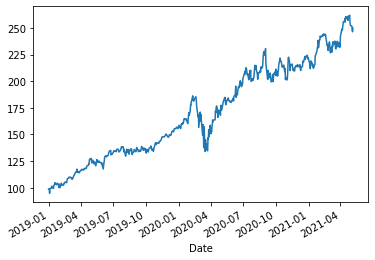

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
from matplotlib import pyplot as plt
import pandas_datareader.data as web##getting data from the website
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# load dataset
start = '2019-01-01'
end = '2021-05-06'

series = pd.Series(web.get_data_yahoo('MSFT', start=start, end=end)['Adj Close'])
# summarize first few rows
print(series.head())
# line plot
series.plot()
plt.show()

In [2]:
# split data into train and test
X = series.values
train, test = X[0:-200], X[-200:]

RMSE: 3.836


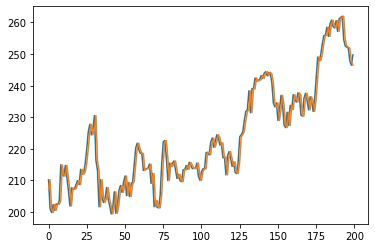

In [3]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    predictions.append(history[-1])
    # observation
    history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test)
plt.plot(predictions)
plt.show()

In [4]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [5]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [6]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [7]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [8]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [9]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [10]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [11]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [12]:
# split data into train and test-sets
train, test = supervised_values[0:-200], supervised_values[-200:]

In [13]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [14]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Day=1, Predicted=208.731828, Expected=210.203629
Day=2, Predicted=210.225286, Expected=201.060898
Day=3, Predicted=204.807747, Expected=199.829971
Day=4, Predicted=202.155234, Expected=202.361343
Day=5, Predicted=202.067196, Expected=200.544693
Day=6, Predicted=201.548032, Expected=202.569794
Day=7, Predicted=202.968493, Expected=202.410965
Day=8, Predicted=203.031020, Expected=203.512848
Day=9, Predicted=204.078512, Expected=214.958664
Day=10, Predicted=210.271054, Expected=211.732391
Day=11, Predicted=213.905397, Expected=211.384949
Day=12, Predicted=211.274592, Expected=214.770050
Day=13, Predicted=215.571896, Expected=210.928314
Day=14, Predicted=211.515808, Expected=206.729202
Day=15, Predicted=208.027260, Expected=201.894775
Day=16, Predicted=203.044768, Expected=207.662354
Day=17, Predicted=207.604406, Expected=207.175903
Day=18, Predicted=207.826311, Expected=207.374451
Day=19, Predicted=207.977560, Expected=208.744370
Day=20, Predicted=209.282071, Expected=209.945541
Day=21, P

Test RMSE: 4.155


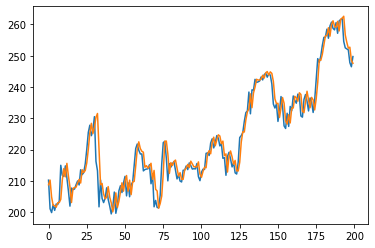

<Figure size 432x288 with 0 Axes>

In [15]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-200:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(raw_values[-200:])
plt.plot(predictions)
plt.show()
plt.savefig('预测结果与实际值.jpg')

In [16]:
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 1500, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-200:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

1) Test RMSE: 4.253
2) Test RMSE: 3.970
3) Test RMSE: 4.858
4) Test RMSE: 5.996
5) Test RMSE: 4.005
6) Test RMSE: 4.585
7) Test RMSE: 86.424
8) Test RMSE: 4.234
9) Test RMSE: 64.807
10) Test RMSE: 19.281
11) Test RMSE: 5.684
12) Test RMSE: 5.296
13) Test RMSE: 4.185
14) Test RMSE: 4.922
15) Test RMSE: 4.825
16) Test RMSE: 79.391
17) Test RMSE: 5.980
18) Test RMSE: 3.853
19) Test RMSE: 142.662
20) Test RMSE: 83.036
21) Test RMSE: 6.911
22) Test RMSE: 4.534
23) Test RMSE: 77.294
24) Test RMSE: 8.045
25) Test RMSE: 49.773
26) Test RMSE: 67.741
27) Test RMSE: 3.927
28) Test RMSE: 5.244
29) Test RMSE: 162.091
30) Test RMSE: 4.575


             rmse
count   30.000000
mean    31.079471
std     44.119160
min      3.853337
25%      4.544731
50%      5.489898
75%     61.048479
max    162.090830


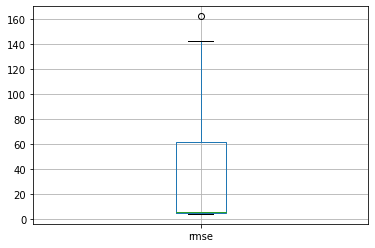

<Figure size 432x288 with 0 Axes>

In [18]:
# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
plt.show()
plt.savefig('rmse分布箱型图.jpg')